In [1]:
from fastbook import *
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

In [2]:
cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(creds)
    cred_path.chmod(0o600)

In [3]:
comp = 'bluebook-for-bulldozers'

In [4]:
path = URLs.path(comp)
path
Path.BASE_PATH = path

In [5]:
 from kaggle import api

# if not path.exists():
#     path.mkdir(parents=true)
#     api.competition_download_cli(comp, path=path)
#     shutil.unpack_archive(str(path/f'{comp}.zip'), str(path))

# path.ls(file_type='text')

General Embeddings nodes:
- categorical variabels can be turned into continuous in a process known as embedding

## Loading in Data

In [6]:
df = pd.read_csv(path/'TrainAndValid.csv', low_memory=False)
# Using low_memory = false to ensure less data processing errors (pandas looks over all data)

In [7]:
df.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'saledate', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc',
       'fiModelSeries', 'fiModelDescriptor', 'ProductSize',
       'fiProductClassDesc', 'state', 'ProductGroup', 'ProductGroupDesc',
       'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control',
       'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension',
       'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics',
       'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size',
       'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow',
       'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb',
       'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type',
       'Travel_Controls', 'Differential_Type', 'Steering_Controls'],
      dtype='object')

In [8]:
# Handling ordinal columns

df['ProductSize'].unique()

array([nan, 'Medium', 'Small', 'Large / Medium', 'Mini', 'Large', 'Compact'], dtype=object)

In [9]:
sizes = 'Large','Large / Medium','Medium','Small','Mini','Compact'
df['ProductSize'] = df['ProductSize'].astype('category')
df['ProductSize'].cat.set_categories(sizes, ordered=True)

0            NaN
1         Medium
2            NaN
3          Small
4            NaN
           ...  
412693      Mini
412694      Mini
412695      Mini
412696      Mini
412697      Mini
Name: ProductSize, Length: 412698, dtype: category
Categories (6, object): ['Large' < 'Large / Medium' < 'Medium' < 'Small' < 'Mini' < 'Compact']

In [10]:
dep_var = 'SalePrice'
df[dep_var] = np.log(df[dep_var]) # to match the kaggle submission

In [11]:
df = add_datepart(df, 'saledate') # using a fast-ai function to turn dates into a series of metadata columns

/home/kyan/mambaforge/lib/python3.10/site-packages/fastai/tabular/core.py:23: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.


In [12]:
df_test = pd.read_csv(path/'Test.csv', low_memory=False)
df_test = add_datepart(df_test, 'saledate')

/home/kyan/mambaforge/lib/python3.10/site-packages/fastai/tabular/core.py:23: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.


In [13]:
# this creates lots of new columns
" ".join([o for o in df.columns if o.startswith("sale")])

'saleYear saleMonth saleWeek saleDay saleDayofweek saleDayofyear saleIs_month_end saleIs_month_start saleIs_quarter_end saleIs_quarter_start saleIs_year_end saleIs_year_start saleElapsed'

Further cleaning using fast-ai TabularPandas

In [14]:
procs = [Categorify, FillMissing]
#turns columns into numeric categorical columns and fillmissing replaces missing with median, and marks row as true

In [15]:
df.saleYear < 2011

0          True
1          True
2          True
3         False
4          True
          ...  
412693    False
412694    False
412695    False
412696    False
412697    False
Name: saleYear, Length: 412698, dtype: bool

In [16]:
# We can split our training data into train and test sets based on date
cond = (df.saleYear < 2011) | ((df.saleYear ==  2011) & (df.saleMonth < 10))
train_idx = np.where( cond)[0]
test_idx = np.where(~cond)[0]

#np.where returns array of trues

In [17]:
splits = list(train_idx), list(test_idx)

In [18]:
cont,cat = cont_cat_split(df, 1, dep_var=dep_var)

In [19]:
# to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)
to = load_pickle(path/'to.pkl')

In [20]:
len(to.train),len(to.valid)

(393137, 19561)

In [21]:
to.show(3) # 

,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,auctioneerID_na,MachineHoursCurrentMeter_na,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,saleYear,saleMonth,saleWeek,saleDay,saleDayofweek,saleDayofyear,saleElapsed,SalePrice
0,Low,521D,521,D,#na#,#na#,#na#,Wheel Loader - 110.0 to 120.0 Horsepower,Alabama,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,False,False,1139246,999089,3157,121,3.0,2004,68.0,2006,11,46,16,3,320,1.163635e+09,11.097410
1,Low,950FII,950,F,II,#na#,Medium,Wheel Loader - 150.0 to 175.0 Horsepower,North Carolina,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,23.5,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,False,False,1139248,117657,77,121,3.0,1996,4640.0,2004,3,13,26,4,86,1.080259e+09,10.950807
2,High,226,226,#na#,#na#,#na#,#na#,Skid Steer Loader - 1351.0 to 1601.0 Lb Operating Capacity,New York,SSL,Skid Steer Loaders,#na#,OROPS,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Auxiliary,#na#,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,None or Unspecified,Standard,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,False,False,False,False,False,False,False,False,1139249,434808,7009,121,3.0,2001,2838.0,2004,2,9,26,3,57,1.077754e+09,9.210340


In [22]:
# underlying is still numeric
to.items.head(3)

,SalesID,SalePrice,MachineID,ModelID,...,saleIs_year_start,saleElapsed,auctioneerID_na,MachineHoursCurrentMeter_na
0,1139246,11.097410,999089,3157,...,1,1.163635e+09,1,1
1,1139248,10.950807,117657,77,...,1,1.080259e+09,1,1
2,1139249,9.210340,434808,7009,...,1,1.077754e+09,1,1


In [23]:
# save_pickle(path/'to.pkl',to)

In [24]:
xs, y = to.train.xs, to.train.y
valid_xs, valid_y = to.valid.xs, to.valid.y

In [25]:
m = DecisionTreeRegressor(max_leaf_nodes = 4)
m.fit(xs, y)

DecisionTreeRegressor(max_leaf_nodes=4)

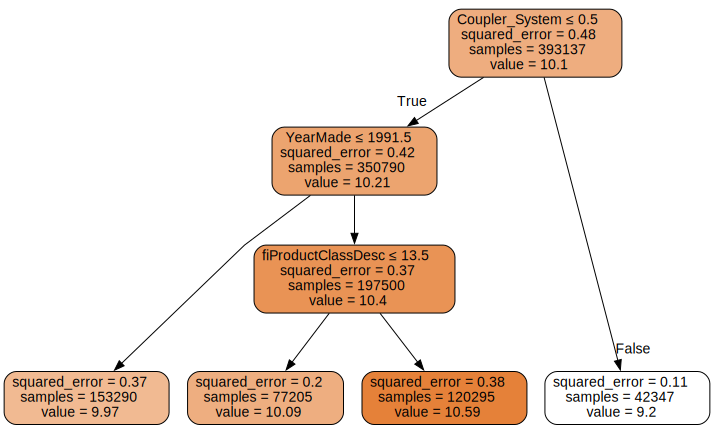

In [26]:
draw_tree(m, xs, size=10, leaves_parallel=True, precision=2)

In [31]:
import dtreeviz

/home/kyan/mambaforge/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names


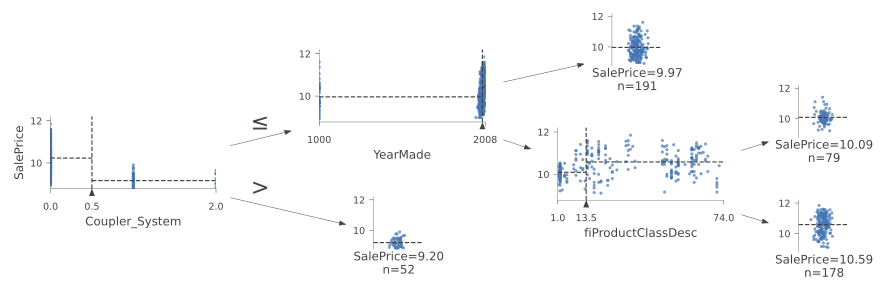

In [43]:
samp_idx = np.random.permutation(len(y))[:500]

viz = dtreeviz.model(m, xs.iloc[samp_idx], y.iloc[samp_idx], feature_names = xs.columns,target_name = dep_var)

# viz.view(fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
# orientation='LR')
viz.view(fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
orientation='LR')

In [44]:
xs.loc[xs['YearMade']<1900, 'YearMade'] = 1950
valid_xs.loc[valid_xs['YearMade']<1900, 'YearMade'] = 1950

/home/kyan/mambaforge/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names


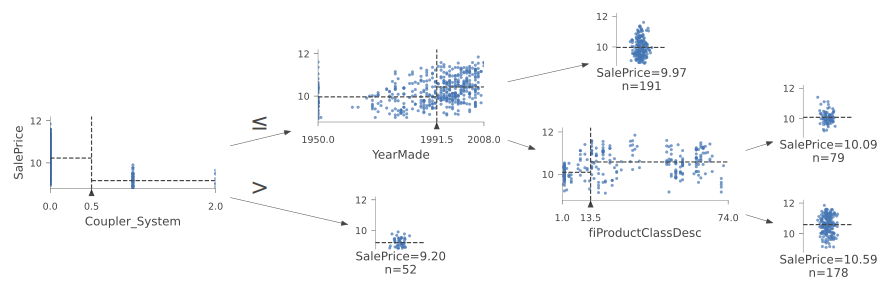

In [45]:
viz = dtreeviz.model(m, xs.iloc[samp_idx], y.iloc[samp_idx], feature_names = xs.columns,target_name = dep_var)

# viz.view(fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
# orientation='LR')
viz.view(fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
orientation='LR')

### Examples of overfitting:

In [46]:
m = DecisionTreeRegressor()
m.fit(xs, y)

DecisionTreeRegressor()

In [47]:
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [48]:
m_rmse(m, xs, y)

0.0

In [50]:
m_rmse(m, valid_xs, valid_y)
#high validation loss

0.368837

In [52]:
m.get_n_leaves(), len(xs)
#nearly as many leaf nodes as data points

(315638, 393137)

In [53]:
m = DecisionTreeRegressor(min_samples_leaf = 25)
m.fit(to.train.xs, to.train.y)
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.23965, 0.325499)

In [54]:
m.get_n_leaves()

12016